In [33]:
from typing import *
import os
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import swifter
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from tqdm.notebook import tqdm
from nptyping import NDArray, Shape, Int, Float
from rich import print as rprint

sns.set_style('whitegrid')
colors = ['#de3838', '#007bc3', '#ffd12a']
markers = ['o', 'x', ',']
%config InlineBackend.figure_formats = ['svg']

cmap = sns.diverging_palette(255, 0, as_cmap=True)  # カラーパレットの定義
DATA_DIR = Path()/'..'/'..'/'data'
DF_DIR = DATA_DIR/'dataframes'

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# 31

df_uselog: pd.DataFrame = pd.read_csv(DATA_DIR/'use_log.csv')
df_customer: pd.DataFrame = pd.read_pickle(DF_DIR/'customer_join_k30.pkl')

display(df_uselog.isnull().sum())
display(df_customer.isnull().sum())

log_id         0
customer_id    0
usedate        0
dtype: int64

customer_id             0
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flag            0
calc_date               0
membership_period       0
dtype: int64

In [17]:
# 32

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


df_customer: pd.DataFrame = pd.read_pickle(DF_DIR/'customer_join_k30.pkl')

columns = ['mean', 'median', 'max', 'min', 'membership_period']
df_customer_clustering: pd.DataFrame = df_customer[columns]
display(df_customer_clustering.tail(2))


def calc_cluster(df: pd.DataFrame, num_clusters: int):
    df = df.copy()
    sc: StandardScaler = StandardScaler()
    df_std: pd.DataFrame = sc.fit_transform(df)

    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    clusters = kmeans.fit(df_std)
    df['cluster'] = clusters.labels_

    return df


df_customer_clustering = calc_cluster(df=df_customer_clustering, num_clusters=4)
display(df_customer_clustering.tail(2))
print(f'cluster types: {df_customer_clustering["cluster"].unique()}')

df_customer_clustering.to_pickle(DF_DIR/'customer_clustering_k32.pkl')

,mean,median,max,min,membership_period
4190,11.0,11.0,11,11,1
4191,10.0,10.0,10,10,1


,mean,median,max,min,membership_period,cluster
4190,11.0,11.0,11,11,1,0
4191,10.0,10.0,10,10,1,0


cluster types: [1 2 3 0]


In [21]:
# 33

df_customer_clustering = pd.read_pickle(DF_DIR/'customer_clustering_k32.pkl')

columns = ['月内平均値', '月内中央値', '月内最大値', '月内最小値', '会員期間', 'cluster']
df_customer_clustering.columns = columns

display(df_customer_clustering.groupby('cluster').count())
display(df_customer_clustering.groupby('cluster').mean())

df_customer_clustering.to_pickle(DF_DIR/'customer_clustering_k33.pkl')

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間
cluster,,,,,
0,840,840,840,840,840
1,1249,1249,1249,1249,1249
2,771,771,771,771,771
3,1332,1332,1332,1332,1332


,月内平均値,月内中央値,月内最大値,月内最小値,会員期間
cluster,,,,,
0,8.061942,8.047024,10.014286,6.175000,7.019048
1,4.677561,4.670937,7.233787,2.153723,36.915933
2,3.065504,2.900130,4.783398,1.649805,9.276265
3,5.539535,5.391141,8.756006,2.702703,14.867868


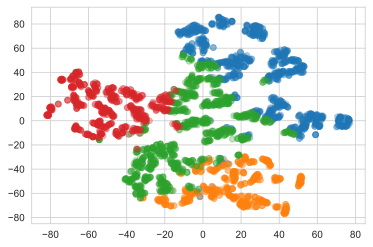

In [31]:
# 34

# from umap import UMAP
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

df_customer_clustering = pd.read_pickle(DF_DIR/'customer_clustering_k32.pkl')


def convert_std(df):
    df = df.copy()
    sc: StandardScaler = StandardScaler()
    df_std = sc.fit_transform(df)
    return df_std


customer_std = convert_std(df=df_customer_clustering.drop('cluster', axis=1))

# X_comp = UMAP(n_components=2, random_state=42).fit_transform(customer_std)
X_comp = TSNE(n_components=2, random_state=42).fit_transform(customer_std)
df_comp = pd.DataFrame(X_comp)
df_comp['cluster'] = df_customer_clustering['cluster']


for c in df_comp['cluster'].unique():
    coord = df_comp.loc[df_comp['cluster'] == c]
    plt.scatter(coord[0], coord[1], alpha=0.3)
plt.show()

In [42]:
# 35

df_customer_clustering: pd.DataFrame = pd.read_pickle(DF_DIR/'customer_clustering_k33.pkl')
df_customer: pd.DataFrame = pd.read_pickle(DF_DIR/'customer_join_k30.pkl')

df_customer_clustering = pd.concat([df_customer_clustering, df_customer], axis=1)

display(df_customer_clustering.groupby(['cluster', 'is_deleted'], as_index=False).count()[['cluster', 'is_deleted', 'customer_id']])
display(df_customer_clustering.groupby(['cluster', 'routine_flag'], as_index=False).count()[['cluster', 'routine_flag', 'customer_id']])

df_customer_clustering.to_pickle(DF_DIR/'customer_clustering_k35.pkl')

,cluster,is_deleted,customer_id
0,0,0,821
1,0,1,19
2,1,0,1231
3,1,1,18
4,2,1,771
5,3,0,790
6,3,1,542


,cluster,routine_flag,customer_id
0,0,0,52
1,0,1,788
2,1,0,2
3,1,1,1247
4,2,0,499
5,2,1,272
6,3,0,226
7,3,1,1106


In [75]:
# 36

df_uselog: pd.DataFrame = pd.read_csv(DATA_DIR/'use_log.csv')

df_uselog['usedate'] = pd.to_datetime(df_uselog['usedate'])
df_uselog['年月'] = df_uselog['usedate'].dt.strftime('%Y%m')
df_uselog_months: pd.DataFrame = df_uselog.groupby(['年月', 'customer_id'], as_index=False).count()
df_uselog_months.rename(columns={'log_id': 'count'}, inplace=True)
del df_uselog_months['usedate']
display(df_uselog_months)

year_months = list(df_uselog_months['年月'].unique())
predict_data: pd.DataFrame = pd.DataFrame()
for i in range(6, len(year_months)):
    temp = df_uselog_months.loc[df_uselog_months['年月']==year_months[i]].copy()
    temp.rename(columns={'count': 'target_count'}, inplace=True)
    for j in range(1, 7):
        temp_before = df_uselog_months.loc[df_uselog_months['年月']==year_months[i-j]].copy()
        del temp_before['年月']
        temp_before.rename(columns={'count': f'{j}m_ago_count'}, inplace=True)
        temp = pd.merge(temp, temp_before, on='customer_id', how='left')
    predict_data = pd.concat([predict_data, temp], ignore_index=True)

predict_data = predict_data.dropna()
predict_data = predict_data.reset_index(drop=True)


display(predict_data)

predict_data.to_pickle(DF_DIR/'predict_data_k36.pkl')
df_uselog_months.to_pickle(DF_DIR/'uselog_months_k36.pkl')

,年月,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7
...,...,...,...
36837,201903,TS995853,8
36838,201903,TS998593,8
36839,201903,TS999079,3
36840,201903,TS999231,6


,年月,customer_id,target_count,1m_ago_count,2m_ago_count,3m_ago_count,4m_ago_count,5m_ago_count,6m_ago_count
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0
...,...,...,...,...,...,...,...,...,...
15108,201903,TS995299,3,3.0,5.0,4.0,5.0,4.0,5.0
15109,201903,TS998593,8,7.0,8.0,7.0,9.0,9.0,9.0
15110,201903,TS999079,3,2.0,6.0,9.0,6.0,6.0,4.0
15111,201903,TS999231,6,6.0,3.0,8.0,5.0,5.0,4.0


In [66]:
# 37

from dateutil.relativedelta import relativedelta


df_predict_data: pd.DataFrame = pd.read_pickle(DF_DIR/'predict_data_k36.pkl')
df_customer: pd.DataFrame = pd.read_pickle(DF_DIR/'customer_join_k30.pkl')

df_predict_data = pd.merge(df_predict_data, df_customer[['customer_id', 'start_date']], on='customer_id', how='left')
df_predict_data['start_date'] = pd.to_datetime(df_predict_data['start_date'])
df_predict_data['now_date'] = pd.to_datetime(df_predict_data['年月'], format='%Y%m')
display(df_predict_data.tail(2))

def calc_membership_period(row: pd.Series) -> int:
    start_date: datetime = row['start_date']
    now_date: datetime = row['now_date']
    delta: relativedelta = relativedelta(now_date, start_date)
    return delta.years*12 + delta.months

df_predict_data['period'] = df_predict_data.swifter.apply(calc_membership_period, axis=1)

display(df_predict_data.tail(2))

df_predict_data.to_pickle(DF_DIR/'predict_data_k37.pkl')

,年月,customer_id,target_count,1m_ago_count,2m_ago_count,3m_ago_count,4m_ago_count,5m_ago_count,6m_ago_count,start_date,now_date
15111,201903,TS999231,6,6.0,3.0,8.0,5.0,5.0,4.0,2017-03-01,2019-03-01
15112,201903,TS999855,4,4.0,7.0,5.0,4.0,4.0,5.0,2017-04-01,2019-03-01


Pandas Apply:   0%|          | 0/15113 [00:00<?, ?it/s]

,年月,customer_id,target_count,1m_ago_count,2m_ago_count,3m_ago_count,4m_ago_count,5m_ago_count,6m_ago_count,start_date,now_date,period
15111,201903,TS999231,6,6.0,3.0,8.0,5.0,5.0,4.0,2017-03-01,2019-03-01,24
15112,201903,TS999855,4,4.0,7.0,5.0,4.0,4.0,5.0,2017-04-01,2019-03-01,23


In [74]:
# 38

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

df_predict_data: pd.DataFrame = pd.read_pickle(DF_DIR/'predict_data_k37.pkl')
df_predict_data = df_predict_data[df_predict_data['start_date'] >= pd.to_datetime('20180401')]

features = ['1m_ago_count', '2m_ago_count', '3m_ago_count', '4m_ago_count', '5m_ago_count', '6m_ago_count', 'period']
X = df_predict_data[features]
y = df_predict_data['target_count']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

model = LinearRegression()
model.fit(X_train, y_train)

print(f'train score: {model.score(X_train, y_train)}')
print(f'test score: {model.score(X_test, y_test)}')


# 39

df_coef = pd.DataFrame({'feature_names': X.columns, 'coefficient': model.coef_})
display(df_coef)


train score: 0.6111525903215709
test score: 0.5964633323568844


,feature_names,coefficient
0,1m_ago_count,0.359133
1,2m_ago_count,0.181937
2,3m_ago_count,0.151177
3,4m_ago_count,0.184593
4,5m_ago_count,0.076946
5,6m_ago_count,0.058731
6,period,0.047007
